<a href="https://colab.research.google.com/github/Storm00212/QUANT/blob/main/Quant_volatility_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D


In [3]:
#Generate random trade returns
np.random.seed(42)

T = 1200            # time points
mu = 0.0003         # drift
sigma = 0.012       # volatility

returns = mu + sigma * np.random.randn(T)


In [4]:
# rolling statistics
def rolling_mean(x, w):
    return np.convolve(x, np.ones(w)/w, mode='valid')

def rolling_variance(x, w):
    return np.convolve(x**2, np.ones(w)/w, mode='valid')


In [5]:
# lag kernel volatility term
def lag_kernel(returns, t, lag, W):
    r_t = returns[t-W:t]
    r_l = returns[t-W-lag:t-lag]

    mu_t = np.mean(r_t)
    mu_l = np.mean(r_l)

    return np.mean((r_t - mu_t) * (r_l - mu_l))


In [6]:
# quantile  volatility floor
def volatility_floor(returns, t, W, K, q=0.75):
    variances = []
    for k in range(K):
        window = returns[t-k-W:t-k]
        variances.append(np.mean(window**2))
    return np.quantile(variances, q)


In [7]:
# volatility surface
W = 50        # rolling window
K = 30        # quantile depth
max_lag = 40

time_idx = range(W + max_lag + K, T)
lags = range(1, max_lag + 1)

S = np.zeros((len(time_idx), len(lags)))

for i, t in enumerate(time_idx):
    floor = volatility_floor(returns, t, W, K)
    for j, l in enumerate(lags):
        kernel = lag_kernel(returns, t, l, W)
        S[i, j] = kernel + floor


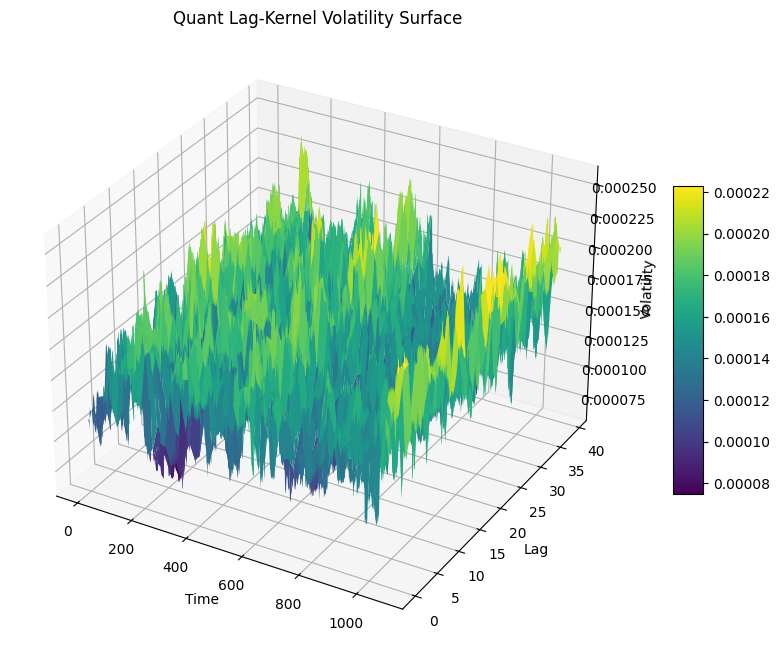

In [8]:
# 3d volatility surface
T_grid, L_grid = np.meshgrid(
    np.arange(S.shape[0]),
    np.arange(S.shape[1]),
    indexing='ij'
)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    T_grid, L_grid, S,
    cmap='viridis',
    linewidth=0,
    antialiased=True
)

ax.set_title("Quant Lag-Kernel Volatility Surface")
ax.set_xlabel("Time")
ax.set_ylabel("Lag")
ax.set_zlabel("Volatility")

fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()


In [9]:
# real market data
!pip install yfinance
import yfinance as yf

data = yf.download("^GSPC", start="2018-01-01")
returns = np.log(data['Adj Close']).diff().dropna().values


/tmp/ipython-input-3233965629.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^GSPC", start="2018-01-01")
[*********************100%***********************]  1 of 1 completed


KeyError: 'Adj Close'